# Дипломная работа. Даниил Сизов.

### Цель дипломной работы - задача бинарной классификации. По целевому значению TARGET определить факт наличия предъявления по гарантии (кредитоспособность клиента).

In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('train_dataset_bank.csv', sep=';')
data

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,...,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,1,1847,01JAN2018:00:00:00,0,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,4650,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4770,01JAN2018:00:00:00,0,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,...,169.0,168.0,18351739.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,4,12237,01JAN2018:00:00:00,0,0,1.937488e+09,122828000.0,6.103280e+08,NaN,809426000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,9988,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17886,17887,3439,07APR2019:00:00:00,0,0,5.404500e+07,NaN,5.404500e+07,NaN,NaN,...,382.0,381.0,45954226.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
17887,17888,838,08APR2019:00:00:00,0,0,NaN,NaN,NaN,NaN,NaN,...,193.0,184.0,134417510.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN
17888,17889,10537,08APR2019:00:00:00,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17889,17890,1751,08APR2019:00:00:00,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.duplicated().sum() # Количество дубликатов в данных

0

In [5]:
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17891 entries, 0 to 17890
Data columns (total 124 columns):
 #    Column                      Non-Null Count  Dtype  
---   ------                      --------------  -----  
 0    id_contract                 17891 non-null  int64  
 1    id_client                   17891 non-null  int64  
 2    SIGN_DATE                   17891 non-null  object 
 3    IP_flag                     17891 non-null  int64  
 4    TARGET                      17891 non-null  int64  
 5    F1100                       6936 non-null   float64
 6    F1110                       1420 non-null   float64
 7    F1150                       6341 non-null   float64
 8    F1160                       346 non-null    float64
 9    F1170                       1499 non-null   float64
 10   F1180                       2500 non-null   float64
 11   F1190                       1520 non-null   float64
 12   F1200                       11850 non-null  float64
 13   F1210         

<ipython-input-5-c1a516913eb1>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  data.info(verbose=True, null_counts=True)


### 1. Проведём аналитику данных.
#### а) Рассмотрим пункты от 0 до 4. Пункты 0 (id_contract), 1 (id_client), 2 (SIGN_DATE) удалим из списка из-за безинформативности для машинной модели. Пункт 4 (TARGET) - цель скорринга.
#### б) Рассмотрим пункты от 5 (F1100) до 49 (F2400_LAG1 ). Это форма бухгалтерского баланса и отчета о финансовых результатах, где в кодировку XX00 входят составляющие XXN0. Согласно модели Э. Альтмана основными составляющими для определения банкротства являются следующие факторы: 12 (F1200), 29 (F1500), 34 (F1600), 36 (F2100), 42 (F2300), 48 (F2400). Остальные пункты из списка удалим.
#### в) Рассмотрим пункты от 50 (F1150_LAG1) до 63 (F2400_LAG1). Это данные бухгалтерского баланса и отчета о финансовых результатах за предыдущий год. Эти данные удалим из списка из-за избыточности.
#### г) Рассмотри пункты от 64 (EGRPOINCLUDED) до 86 (OKVED_CODE). Кроме пунктов 69 и 73 удалим данные из списка из-за избыточной информативности. Оставим пункт 69, так как от региона зависит экономическое благополучие. Оставим пункт 73, так как корреляция численности персонала и прибыли важна.
#### д) Рассмотрим пункты от 87 (PLAINTIFF_CASESNUMBER_YEAR) до 96 (THIRDOROTHERPERSON_EVER). Это данные об участиях в судах. Эти данные полезны, так как показывают конфликтность клиента как за последний год, так и за всё время.
#### е) Рассмотрим пункты от 97 (ADMITTEDNUMBER_233_YEAR) до  116 (SUM_95_EVER). Это данные о тендерах и госконтрактах. Удалим эти данные, так как недопуск к ним мог произойти по причинам, не зависищих от клиента, а число допусков не является решающим значением.
#### ж) Рассмотрим пункты от 117 до 123. Из данного списка удалим пункт 120 (BIRTHDATE), так как он избыточен для машинной модели.


In [6]:
drop_cols = [0, 1, 2,
             5, 6, 7, 8, 9, 10, 11,
             13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
             30, 31, 32, 33,
             35,
             37, 38, 39, 40, 41,
             43, 44, 45, 46, 47,
             49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
             64, 65, 66, 67, 68,
             70, 71, 72, 
             74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
             97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
             120]
data = data.drop(data.columns[drop_cols], axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17891 entries, 0 to 17890
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IP_flag                     17891 non-null  int64  
 1   TARGET                      17891 non-null  int64  
 2   F1200                       11850 non-null  float64
 3   F1500                       11614 non-null  float64
 4   F1600                       11870 non-null  float64
 5   F2100                       7550 non-null   float64
 6   F2300                       11530 non-null  float64
 7   F2400                       11510 non-null  float64
 8   OKATO_REGIONCODE            16559 non-null  float64
 9   WORKERSRANGE                13911 non-null  object 
 10  PLAINTIFF_CASESNUMBER_YEAR  3932 non-null   float64
 11  PLAINTIFF_SUM_YEAR          3932 non-null   float64
 12  DEFENDANT_CASESNUMBER_YEAR  3932 non-null   float64
 13  DEFENDANT_SUM_YEAR          393

#### Оценим некоторые численные данные.

In [8]:
data['IP_flag'].value_counts()

0    14391
1     3500
Name: IP_flag, dtype: int64

In [9]:
data['OKATO_REGIONCODE'].value_counts()

45.0    2897
46.0    1006
40.0     886
65.0     787
3.0      641
        ... 
84.0      16
77.0      10
99.0       8
26.0       8
55.0       4
Name: OKATO_REGIONCODE, Length: 83, dtype: int64

In [10]:
data['AGE'].value_counts()

32.0    175
31.0     71
48.0     63
33.0     61
36.0     51
42.0     50
43.0     48
40.0     48
34.0     42
27.0     41
44.0     40
47.0     39
38.0     38
60.0     38
39.0     37
37.0     36
35.0     33
41.0     32
50.0     30
55.0     29
51.0     28
49.0     28
54.0     27
58.0     25
45.0     24
53.0     23
56.0     22
52.0     22
30.0     21
46.0     20
29.0     20
61.0     19
57.0     17
23.0     15
59.0     14
63.0     13
65.0     10
64.0      9
25.0      9
28.0      9
26.0      8
62.0      5
68.0      4
69.0      4
66.0      4
22.0      4
67.0      4
24.0      2
78.0      2
74.0      1
73.0      1
21.0      1
70.0      1
71.0      1
Name: AGE, dtype: int64

#### Проверим объектные (категориальные) данные.

In [11]:
data['WORKERSRANGE'].value_counts()

0 .. 5          6183
16 .. 50        2181
6 .. 10         1668
51 .. 100        791
11 .. 15         656
1001 .. 5000     592
501 .. 1000      557
251 .. 500       508
101 .. 150       258
151 .. 200       186
201 .. 250       166
5000 � �����     165
Name: WORKERSRANGE, dtype: int64

In [12]:
data['SEX_NAME'].value_counts()

�������    2168
Name: SEX_NAME, dtype: int64

In [13]:
data['CITIZENSHIP_NAME'].value_counts()

���������� ���������    2124
�����������                2
�������                    1
���������                  1
Name: CITIZENSHIP_NAME, dtype: int64

#### Столбцы 'SEX_NAME' и 'CITIZENSHIP_NAME' неинформативны, их придётся удалить.

In [14]:
drop_cols = ['SEX_NAME', 'CITIZENSHIP_NAME']
data = data.drop(drop_cols, axis=1)

#### Проверим данные на аномальность. Согласно Федеральному закону "О бухгалтерском учёте" п. 1, ст. 6 "Экономический субъект обязан вести бухгалтерский учет в соответствии с настоящим Федеральным законом, если иное не установлено настоящим Федеральным законом". Это значит, что у всех экономических субъектов в столбце F2400 (Прибыль(убыток)) должны стоять какие-либо числовые данные. Однако, согласно п. 2, ст. 6 "Бухгалтерский учет в соответствии с настоящим Федеральным законом могут не вести: [ИП и пр.]", тоесть данных может не быть. Выдвиним гипотезу:"Если данных нет, то TARGET = 0". Если это не так, значит все ИП должны входить в эту выборку. Проверим это.

In [15]:
df = data[data['F2400'].isnull()] # выборка данных с датафреймом, где F2400 = NaN (нет данных)
df['TARGET'].value_counts()

0    3295
1    3086
Name: TARGET, dtype: int64

In [16]:
df['IP_flag'].value_counts() # количество ИП и не ИП в датафрейме, где F2400 = NaN (нет данных)

1    3500
0    2881
Name: IP_flag, dtype: int64

In [17]:
data['IP_flag'].value_counts() # количество ИП и не ИП в полном датафрейме

0    14391
1     3500
Name: IP_flag, dtype: int64

#### Мы видим, что количество ИП (3500) в датафрейме data равняется количеству ИП (3500) в датафрейме df, где F2400 = NaN. Значит данные не аномальные.

#### Проверим пункт 19 "FLAG_DISQUALIFICATION" на адекватность предсказания TARGET (должно быть 0 из-за дисквалификационного руководителя). Если TARGET = 1, значит данных для пункта 19 недостаточно и эти данные - аномальные.

In [18]:
data[data['FLAG_DISQUALIFICATION'].notna()]

,IP_flag,TARGET,F1200,F1500,F1600,F2100,F2300,F2400,OKATO_REGIONCODE,WORKERSRANGE,...,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,AGE
9811,0,1,NaN,NaN,NaN,NaN,NaN,NaN,56.0,6 .. 10,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
10368,0,1,NaN,NaN,NaN,NaN,NaN,NaN,56.0,6 .. 10,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
11815,0,1,NaN,NaN,NaN,NaN,NaN,NaN,56.0,6 .. 10,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
16633,0,1,9473000.0,9394000.0,9473000.0,411000.0,268000.0,79000.0,56.0,6 .. 10,...,0.0,1.0,19369.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
17205,0,1,9473000.0,9394000.0,9473000.0,411000.0,268000.0,79000.0,56.0,6 .. 10,...,0.0,1.0,19369.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN


#### Данные аномальные, их следует удалить.

In [19]:
drop_cols = ['FLAG_DISQUALIFICATION']
data = data.drop(drop_cols, axis=1)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17891 entries, 0 to 17890
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IP_flag                     17891 non-null  int64  
 1   TARGET                      17891 non-null  int64  
 2   F1200                       11850 non-null  float64
 3   F1500                       11614 non-null  float64
 4   F1600                       11870 non-null  float64
 5   F2100                       7550 non-null   float64
 6   F2300                       11530 non-null  float64
 7   F2400                       11510 non-null  float64
 8   OKATO_REGIONCODE            16559 non-null  float64
 9   WORKERSRANGE                13911 non-null  object 
 10  PLAINTIFF_CASESNUMBER_YEAR  3932 non-null   float64
 11  PLAINTIFF_SUM_YEAR          3932 non-null   float64
 12  DEFENDANT_CASESNUMBER_YEAR  3932 non-null   float64
 13  DEFENDANT_SUM_YEAR          393

#### Заполнение недостающих данных. В данной модели лучшим вариантом будет присвоить всем NaN нули, чтобы не искажать другие данные, кроме столбцов "AGE" и "WORKERSRANGE". В столбце "AGE" используем заполнение по моде, предполагая, что большинство неуказанных данных о возрасте принадлежит большинству. В столбце "WORKERSRANGE" значению NaN присваиваем объектное (категориальное) значение 'Other', так как другие значения также объектные.

In [21]:
data['AGE'].value_counts()

32.0    175
31.0     71
48.0     63
33.0     61
36.0     51
42.0     50
43.0     48
40.0     48
34.0     42
27.0     41
44.0     40
47.0     39
38.0     38
60.0     38
39.0     37
37.0     36
35.0     33
41.0     32
50.0     30
55.0     29
51.0     28
49.0     28
54.0     27
58.0     25
45.0     24
53.0     23
56.0     22
52.0     22
30.0     21
46.0     20
29.0     20
61.0     19
57.0     17
23.0     15
59.0     14
63.0     13
65.0     10
64.0      9
25.0      9
28.0      9
26.0      8
62.0      5
68.0      4
69.0      4
66.0      4
22.0      4
67.0      4
24.0      2
78.0      2
74.0      1
73.0      1
21.0      1
70.0      1
71.0      1
Name: AGE, dtype: int64

In [22]:
data['AGE'] = data['AGE'].fillna(data['AGE'].mode()[0])

In [23]:
data['AGE'].value_counts()

32.0    16647
31.0       71
48.0       63
33.0       61
36.0       51
42.0       50
43.0       48
40.0       48
34.0       42
27.0       41
44.0       40
47.0       39
38.0       38
60.0       38
39.0       37
37.0       36
35.0       33
41.0       32
50.0       30
55.0       29
51.0       28
49.0       28
54.0       27
58.0       25
45.0       24
53.0       23
56.0       22
52.0       22
30.0       21
46.0       20
29.0       20
61.0       19
57.0       17
23.0       15
59.0       14
63.0       13
65.0       10
64.0        9
25.0        9
28.0        9
26.0        8
62.0        5
68.0        4
69.0        4
66.0        4
22.0        4
67.0        4
24.0        2
78.0        2
74.0        1
73.0        1
21.0        1
70.0        1
71.0        1
Name: AGE, dtype: int64

In [24]:
data['WORKERSRANGE'] = data['WORKERSRANGE'].fillna('Other')
data['WORKERSRANGE'].value_counts()

0 .. 5          6183
Other           3980
16 .. 50        2181
6 .. 10         1668
51 .. 100        791
11 .. 15         656
1001 .. 5000     592
501 .. 1000      557
251 .. 500       508
101 .. 150       258
151 .. 200       186
201 .. 250       166
5000 � �����     165
Name: WORKERSRANGE, dtype: int64

In [25]:
data = data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17891 entries, 0 to 17890
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IP_flag                     17891 non-null  int64  
 1   TARGET                      17891 non-null  int64  
 2   F1200                       17891 non-null  float64
 3   F1500                       17891 non-null  float64
 4   F1600                       17891 non-null  float64
 5   F2100                       17891 non-null  float64
 6   F2300                       17891 non-null  float64
 7   F2400                       17891 non-null  float64
 8   OKATO_REGIONCODE            17891 non-null  float64
 9   WORKERSRANGE                17891 non-null  object 
 10  PLAINTIFF_CASESNUMBER_YEAR  17891 non-null  float64
 11  PLAINTIFF_SUM_YEAR          17891 non-null  float64
 12  DEFENDANT_CASESNUMBER_YEAR  17891 non-null  float64
 13  DEFENDANT_SUM_YEAR          178

#### Использование OneHotEncoder для декадирование объектных (категориальных) данных.

In [26]:
from sklearn.preprocessing import OneHotEncoder

In [27]:
ohe = OneHotEncoder()
main_matrix = ohe.fit_transform(data[['WORKERSRANGE']])
main_matrix = main_matrix.toarray()
main_df = pd.DataFrame(main_matrix, columns=ohe.categories_[0])
main_df.index = data.index
train_df = data.join(main_df)
data = data.join(main_df)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17891 entries, 0 to 17890
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IP_flag                     17891 non-null  int64  
 1   TARGET                      17891 non-null  int64  
 2   F1200                       17891 non-null  float64
 3   F1500                       17891 non-null  float64
 4   F1600                       17891 non-null  float64
 5   F2100                       17891 non-null  float64
 6   F2300                       17891 non-null  float64
 7   F2400                       17891 non-null  float64
 8   OKATO_REGIONCODE            17891 non-null  float64
 9   WORKERSRANGE                17891 non-null  object 
 10  PLAINTIFF_CASESNUMBER_YEAR  17891 non-null  float64
 11  PLAINTIFF_SUM_YEAR          17891 non-null  float64
 12  DEFENDANT_CASESNUMBER_YEAR  17891 non-null  float64
 13  DEFENDANT_SUM_YEAR          178

In [28]:
digit_columns = data.dtypes[data.dtypes != 'object'].index.values # удаление остаточных категориальных данных
digit_data = data[digit_columns].copy()
digit_data.head(5).transpose()

,0,1,2,3,4
IP_flag,0.000000e+00,1.0,0.0,0.000000e+00,1.0
TARGET,0.000000e+00,0.0,0.0,0.000000e+00,0.0
F1200,1.048287e+10,0.0,21610000.0,5.786965e+09,0.0
F1500,9.480796e+09,0.0,4248000.0,4.411295e+09,0.0
F1600,1.178183e+10,0.0,94984000.0,7.724453e+09,0.0
F2100,2.370882e+09,0.0,9315000.0,1.694054e+10,0.0
F2300,8.834700e+07,0.0,1190000.0,1.489204e+09,0.0
F2400,3.908700e+07,0.0,655000.0,1.102019e+09,0.0
OKATO_REGIONCODE,3.000000e+00,0.0,33.0,7.100000e+01,0.0
PLAINTIFF_CASESNUMBER_YEAR,0.000000e+00,0.0,6.0,0.000000e+00,0.0


#### Оценка корреляции данных.

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
corr_digit = digit_data.corr()

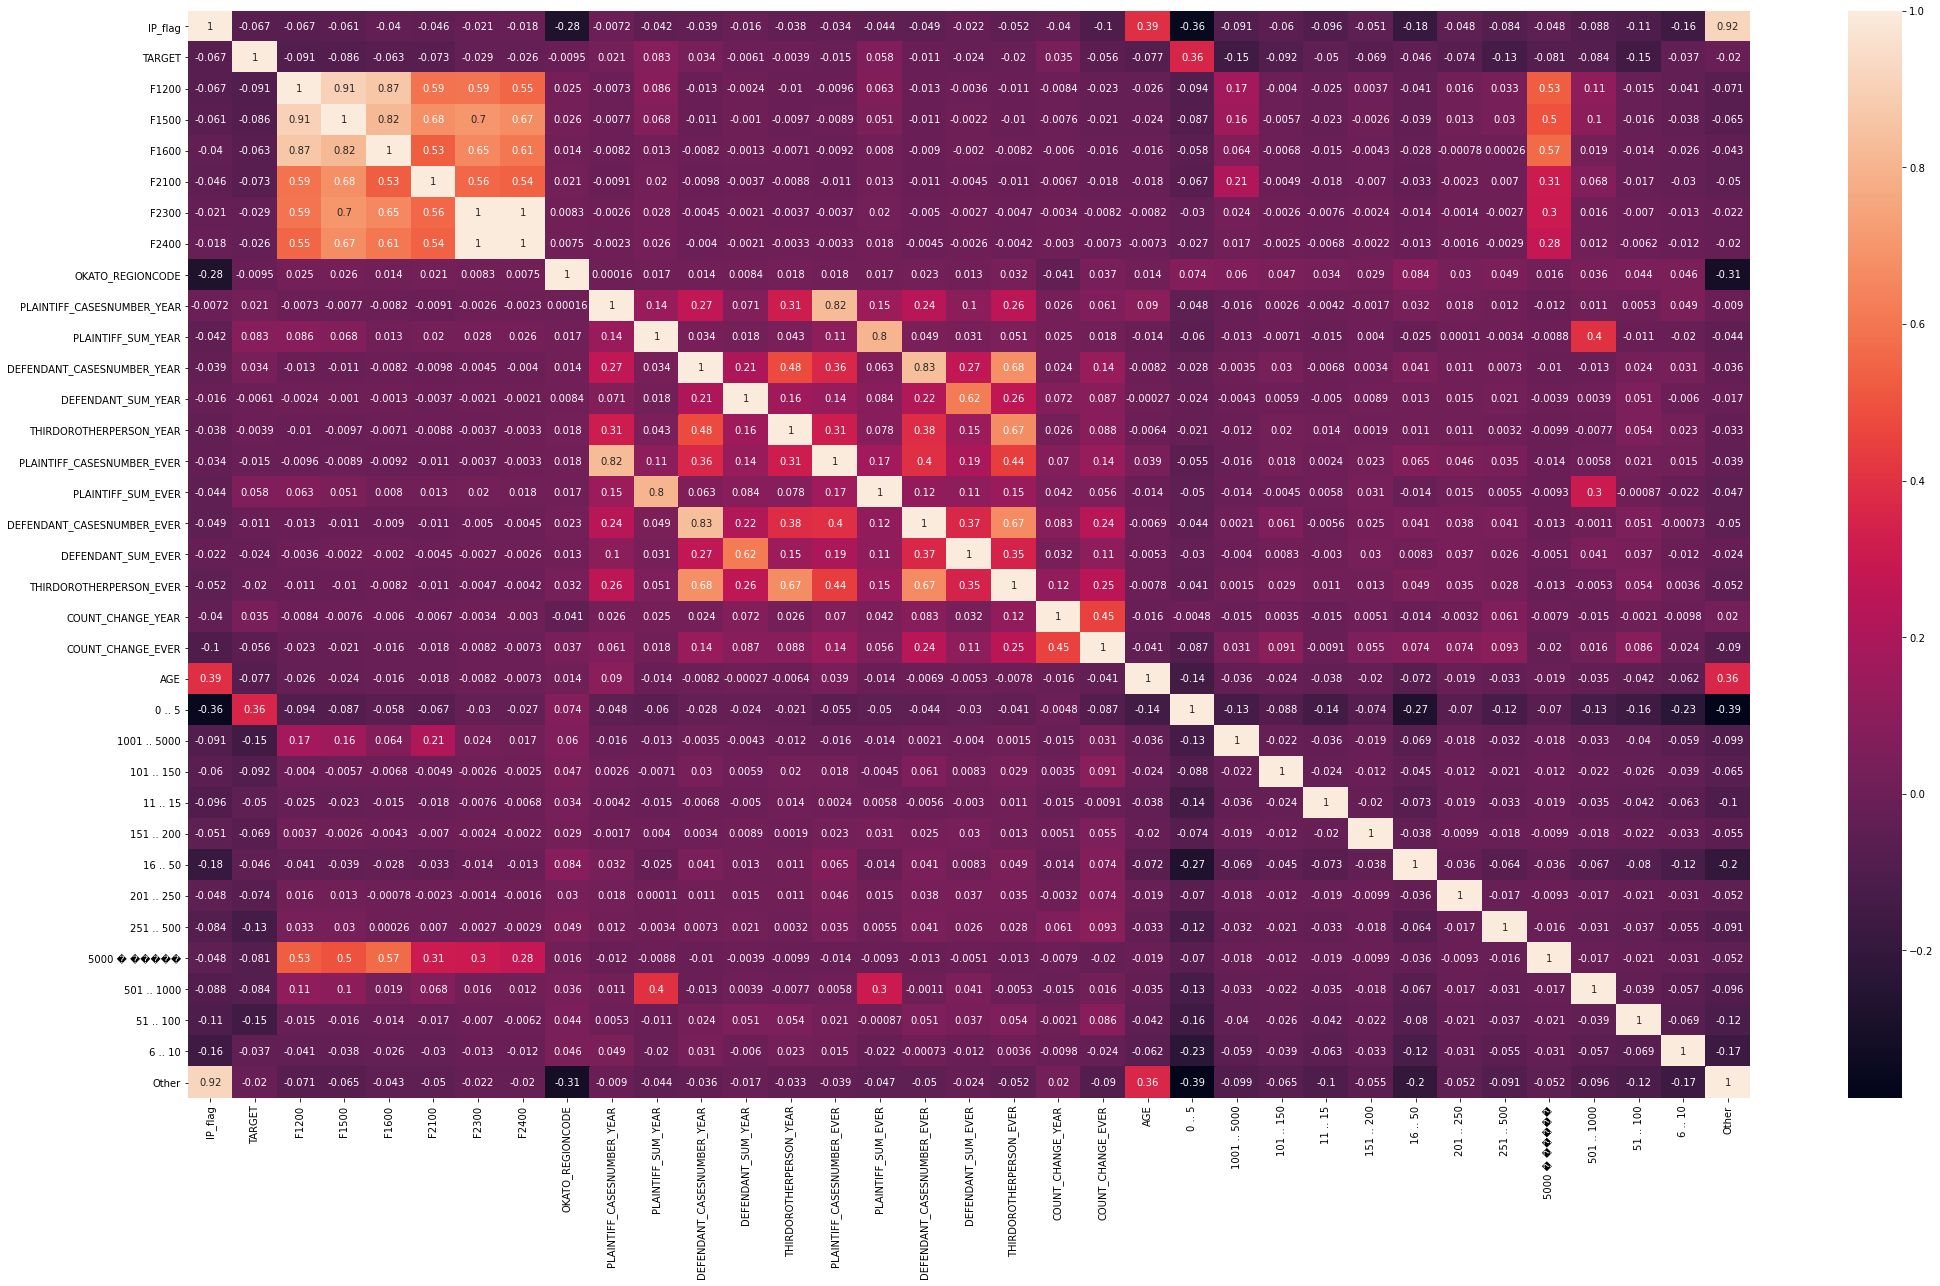

In [31]:
plt.figure(figsize=(35, 20))
sns.heatmap(corr_digit, annot=True)
plt.show()

In [32]:
digit_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
IP_flag,17891.0,1.956291e-01,3.966953e-01,0.000000e+00,0.0,0.0,0.0,1.000000e+00
TARGET,17891.0,4.130010e-01,4.923868e-01,0.000000e+00,0.0,0.0,1.0,1.000000e+00
F1200,17891.0,6.428290e+08,4.721858e+09,-2.950000e+05,0.0,3901000.0,54966000.0,1.742660e+11
F1500,17891.0,6.259578e+08,5.042439e+09,-3.656000e+06,0.0,1735000.0,35753000.0,1.812760e+11
F1600,17891.0,1.877401e+09,2.307553e+10,-2.950000e+05,0.0,4364000.0,61140500.0,1.425040e+12
F2100,17891.0,5.700891e+08,6.099946e+09,-6.795270e+09,0.0,0.0,6924500.0,2.270906e+11
F2300,17891.0,1.164864e+08,2.764826e+09,-8.922047e+09,0.0,187000.0,3722000.0,1.406380e+11
F2400,17891.0,9.162436e+07,2.453012e+09,-8.922047e+09,0.0,108000.0,2926500.0,1.272500e+11
OKATO_REGIONCODE,17891.0,4.090610e+01,2.617173e+01,0.000000e+00,20.0,45.0,60.0,9.900000e+01
PLAINTIFF_CASESNUMBER_YEAR,17891.0,1.204740e+00,9.392613e+00,0.000000e+00,0.0,0.0,0.0,3.340000e+02


#### Нормализация данных. Нормализуем те данные, чей порядок 10^8 и выше.

In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [34]:
stand_data = digit_data.copy()
stand_scale = StandardScaler()
g_cl_stand = stand_scale.fit_transform(stand_data[['F1200', 'F1500', 'F1600', 'F2100', 'F2300', 'F2400',
                                                   'PLAINTIFF_SUM_YEAR', 'DEFENDANT_SUM_YEAR', 'PLAINTIFF_SUM_EVER', 'DEFENDANT_SUM_EVER']])
g_cl_stand

array([[ 2.08399153,  1.75611171,  0.42922962, ..., -0.03996868,
        -0.09687469, -0.05255919],
       [-0.13614281, -0.12414137, -0.08136124, ..., -0.03996868,
        -0.09687469, -0.05255919],
       [-0.13156609, -0.1232989 , -0.0772449 , ..., -0.03991574,
         0.01218491, -0.03145752],
       ...,
       [-0.13548669, -0.12358944, -0.08122698, ..., -0.03996868,
        -0.09687469, -0.05255919],
       [-0.13072128, -0.1191256 , -0.08025185, ..., -0.03996868,
        -0.09687469, -0.05255919],
       [-0.13147227, -0.12219127, -0.08040557, ..., -0.03993535,
        -0.08815848, -0.0512976 ]])

In [35]:
stand_data.loc[:, 'F1200'] = g_cl_stand[:, 0]
stand_data.loc[:, 'F1500'] = g_cl_stand[:, 1]
stand_data.loc[:, 'F1600'] = g_cl_stand[:, 2]
stand_data.loc[:, 'F2100'] = g_cl_stand[:, 3]
stand_data.loc[:, 'F2300'] = g_cl_stand[:, 4]
stand_data.loc[:, 'F2400'] = g_cl_stand[:, 5]
stand_data.loc[:, 'PLAINTIFF_SUM_YEAR'] = g_cl_stand[:, 6]
stand_data.loc[:, 'DEFENDANT_SUM_YEAR'] = g_cl_stand[:, 7]
stand_data.loc[:, 'PLAINTIFF_SUM_EVER'] = g_cl_stand[:, 8]
stand_data.loc[:, 'DEFENDANT_SUM_EVER'] = g_cl_stand[:, 9]
stand_data.describe()[['F1200', 'F1500', 'F1600', 'F2100', 'F2300', 'F2400',
                                                   'PLAINTIFF_SUM_YEAR', 'DEFENDANT_SUM_YEAR', 'PLAINTIFF_SUM_EVER', 'DEFENDANT_SUM_EVER']].transpose()

,count,mean,std,min,25%,50%,75%,max
F1200,17891.0,-1.218352e-15,1.000028,-0.136205,-0.136143,-0.135317,-0.124502,36.771124
F1500,17891.0,-4.559944e-16,1.000028,-0.124866,-0.124141,-0.123797,-0.117051,35.826928
F1600,17891.0,-4.284111e-16,1.000028,-0.081374,-0.081361,-0.081172,-0.078712,61.675818
F2100,17891.0,3.748771e-15,1.000028,-1.207480,-0.093461,-0.093461,-0.092325,37.135883
F2300,17891.0,-1.390145e-16,1.000028,-3.269206,-0.042133,-0.042065,-0.040786,50.826143
F2400,17891.0,2.694417e-16,1.000028,-3.674635,-0.037353,-0.037309,-0.036160,51.839099
PLAINTIFF_SUM_YEAR,17891.0,5.692993e-15,1.000028,-0.090758,-0.090758,-0.090758,-0.090758,17.739456
DEFENDANT_SUM_YEAR,17891.0,3.088035e-15,1.000028,-0.039969,-0.039969,-0.039969,-0.039969,93.803813
PLAINTIFF_SUM_EVER,17891.0,-9.728420e-15,1.000028,-0.096875,-0.096875,-0.096875,-0.096875,62.932431
DEFENDANT_SUM_EVER,17891.0,-2.678269e-15,1.000028,-0.052559,-0.052559,-0.052559,-0.052559,75.096153


## 2. Построение моделей предсказания.
## 2.1. Логистическая регрессия.

In [36]:
X = stand_data.drop(columns=['TARGET'])
y = stand_data['TARGET']

#### Разбиение данных на тренировочную, тестовую и валидационную.

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

#### Подготовка данных с помощью методики PCA.

In [38]:
from sklearn.decomposition import PCA

In [39]:
X_train.shape

(14312, 34)

In [40]:
pca_proc = PCA(n_components=18)
X_train_pca = pca_proc.fit_transform(X_train)
X_test_pca = pca_proc.transform(X_test)
X_valid_pca = pca_proc.transform(X_valid)

#### Логистическая регрессия и метрики.

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logress = LogisticRegression()
logress.fit(X_train, y_train)

train_pred = logress.predict(X_train)
valid_pred = logress.predict(X_valid)
test_pred = logress.predict(X_test)

print('Train metrics:')
print(classification_report(train_pred, y_train))
print('-----------------')
print('Valid metrics:')
print(classification_report(valid_pred, y_valid))
print('-----------------')
print('Test metrics:')
print(classification_report(test_pred, y_test))

Train metrics:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      8866
           1       0.62      0.67      0.65      5446

    accuracy                           0.72     14312
   macro avg       0.70      0.71      0.71     14312
weighted avg       0.72      0.72      0.72     14312

-----------------
Valid metrics:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1075
           1       0.63      0.68      0.66       714

    accuracy                           0.71      1789
   macro avg       0.70      0.71      0.71      1789
weighted avg       0.72      0.71      0.72      1789

-----------------
Test metrics:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76      1089
           1       0.62      0.66      0.64       701

    accuracy                           0.71      1790
   macro avg       0.70      0.70      0.70     

C:\Users\Dsizo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
y_train.value_counts(normalize=True)

0    0.589785
1    0.410215
Name: TARGET, dtype: float64

#### Логистическая регрессия с методом PCA и метрики.

In [43]:
logress = LogisticRegression()
logress.fit(X_train_pca, y_train)

train_pred = logress.predict(X_train_pca)
valid_pred = logress.predict(X_valid_pca)
test_pred = logress.predict(X_test_pca)

print('Train metrics:')
print(classification_report(train_pred, y_train))
print('-----------------')
print('Valid metrics:')
print(classification_report(valid_pred, y_valid))
print('-----------------')
print('Test metrics:')
print(classification_report(test_pred, y_test))

Train metrics:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76      9261
           1       0.57      0.66      0.61      5051

    accuracy                           0.70     14312
   macro avg       0.68      0.69      0.68     14312
weighted avg       0.72      0.70      0.71     14312

-----------------
Valid metrics:
              precision    recall  f1-score   support

           0       0.79      0.71      0.75      1128
           1       0.58      0.68      0.62       661

    accuracy                           0.70      1789
   macro avg       0.68      0.69      0.69      1789
weighted avg       0.71      0.70      0.70      1789

-----------------
Test metrics:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1134
           1       0.57      0.65      0.61       656

    accuracy                           0.69      1790
   macro avg       0.67      0.68      0.68     

C:\Users\Dsizo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Итог. Методом PCA можно существенно понизить размерность датафрейма, не влияя сильно на точность предсказания.

## 2.2. Градиентный бустинг.
## 2.2.1 LGBM booster.

In [44]:
X = stand_data.drop(columns=['TARGET'])
y = stand_data['TARGET']

#### Разбиение данных на тренировочную, тестовую и валидационную.

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [46]:
!pip install lightgbm

#### LGBM booster и метрики.

In [47]:
import lightgbm as lgb
from sklearn.metrics import classification_report

In [48]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train, eval_set=(X_valid, y_valid))

[1]	valid_0's binary_logloss: 0.643006
[2]	valid_0's binary_logloss: 0.609551
[3]	valid_0's binary_logloss: 0.582859
[4]	valid_0's binary_logloss: 0.561104
[5]	valid_0's binary_logloss: 0.541694
[6]	valid_0's binary_logloss: 0.525894
[7]	valid_0's binary_logloss: 0.512356
[8]	valid_0's binary_logloss: 0.49967
[9]	valid_0's binary_logloss: 0.487353
[10]	valid_0's binary_logloss: 0.477486
[11]	valid_0's binary_logloss: 0.467908
[12]	valid_0's binary_logloss: 0.458911
[13]	valid_0's binary_logloss: 0.452002
[14]	valid_0's binary_logloss: 0.445147
[15]	valid_0's binary_logloss: 0.438692
[16]	valid_0's binary_logloss: 0.433035
[17]	valid_0's binary_logloss: 0.428242
[18]	valid_0's binary_logloss: 0.422257
[19]	valid_0's binary_logloss: 0.416413
[20]	valid_0's binary_logloss: 0.413251
[21]	valid_0's binary_logloss: 0.409133
[22]	valid_0's binary_logloss: 0.405139
[23]	valid_0's binary_logloss: 0.401605
[24]	valid_0's binary_logloss: 0.399498
[25]	valid_0's binary_logloss: 0.396648
[26]	valid

LGBMClassifier()

In [49]:
train_pred = clf.predict(X_train)
valid_pred = clf.predict(X_valid)
test_pred = clf.predict(X_test)

print('Train metrics:')
print(classification_report(train_pred, y_train))
print('-----------------')
print('Valid metrics:')
print(classification_report(valid_pred, y_valid))
print('-----------------')
print('Test metrics:')
print(classification_report(test_pred, y_test))

Train metrics:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      8595
           1       0.86      0.88      0.87      5717

    accuracy                           0.90     14312
   macro avg       0.89      0.89      0.89     14312
weighted avg       0.90      0.90      0.90     14312

-----------------
Valid metrics:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1016
           1       0.84      0.83      0.84       773

    accuracy                           0.86      1789
   macro avg       0.86      0.86      0.86      1789
weighted avg       0.86      0.86      0.86      1789

-----------------
Test metrics:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1056
           1       0.81      0.83      0.82       734

    accuracy                           0.85      1790
   macro avg       0.85      0.85      0.85     

## 2.2.2 CatBoost.

In [50]:
!pip install catboost

In [51]:
X = stand_data.drop(columns=['TARGET'])
y = stand_data['TARGET']

#### Разбиение данных на тренировочную, тестовую и валидационную.

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

#### CatBoost и метрики.

In [53]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

In [54]:
model = CatBoostClassifier()
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

Learning rate set to 0.061146
0:	learn: 0.6732165	test: 0.6745941	best: 0.6745941 (0)	total: 167ms	remaining: 2m 47s
1:	learn: 0.6520131	test: 0.6549425	best: 0.6549425 (1)	total: 172ms	remaining: 1m 26s
2:	learn: 0.6339180	test: 0.6381455	best: 0.6381455 (2)	total: 177ms	remaining: 58.8s
3:	learn: 0.6159837	test: 0.6221514	best: 0.6221514 (3)	total: 182ms	remaining: 45.2s
4:	learn: 0.6048684	test: 0.6117149	best: 0.6117149 (4)	total: 187ms	remaining: 37.2s
5:	learn: 0.5911595	test: 0.5989334	best: 0.5989334 (5)	total: 192ms	remaining: 31.7s
6:	learn: 0.5790738	test: 0.5877549	best: 0.5877549 (6)	total: 196ms	remaining: 27.8s
7:	learn: 0.5685809	test: 0.5788937	best: 0.5788937 (7)	total: 201ms	remaining: 24.9s
8:	learn: 0.5574713	test: 0.5676870	best: 0.5676870 (8)	total: 206ms	remaining: 22.7s
9:	learn: 0.5505439	test: 0.5614750	best: 0.5614750 (9)	total: 210ms	remaining: 20.8s
10:	learn: 0.5427936	test: 0.5544983	best: 0.5544983 (10)	total: 215ms	remaining: 19.3s
11:	learn: 0.5374668

In [55]:
train_pred = model.predict(X_train)
valid_pred = model.predict(X_valid)
test_pred = model.predict(X_test)

print('Train metrics:')
print(classification_report(train_pred, y_train))
print('-----------------')
print('Valid metrics:')
print(classification_report(valid_pred, y_valid))
print('-----------------')
print('Test metrics:')
print(classification_report(test_pred, y_test))

Train metrics:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      8488
           1       0.91      0.92      0.91      5824

    accuracy                           0.93     14312
   macro avg       0.93      0.93      0.93     14312
weighted avg       0.93      0.93      0.93     14312

-----------------
Valid metrics:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1031
           1       0.84      0.85      0.85       758

    accuracy                           0.87      1789
   macro avg       0.87      0.87      0.87      1789
weighted avg       0.87      0.87      0.87      1789

-----------------
Test metrics:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1057
           1       0.83      0.85      0.84       733

    accuracy                           0.87      1790
   macro avg       0.86      0.86      0.86     

### Вывод. В данной работе были проанализированы данные, использованы методы  LogisticRegression, LGBMClassifier, CatBoostClassifier для предсказания столбца TARGET. Были получены следующие метрики: f1-score = 0.71 для LogisticRegression, f1-score = 0.89 для LGBMClassifier, f1-score = 0,93 для CatBoostClassifier. Лучше всего отработал метод CatBoostClassifier.